In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input


In [8]:
# !pip install torch timm fastai

In [3]:
import timm
from fastai.vision.all import *
from fastcore.all import *

In [4]:
path = '/kaggle/input/code-to-cure-10/Training'

In [168]:


# Define the transforms to apply
data_augmentation = aug_transforms(
    do_flip=True, 
    flip_vert=True, 
    max_rotate=10.0, 
    max_zoom=1.05, 
    max_lighting=0.2, 
    max_warp=0.1, 
    p_affine=0.75, 
    p_lighting=0.75
)
# transforms = [aug_transforms(do_flip=True, flip_vert=True),
#               Rotate(max_deg=10.0, p=0.75),
#               Zoom(max_zoom=1.1, p=0.75),
#               Warp(p=0.75),
#               RandomBrightnessContrast(p=0.75, brightness_max=0.2, contrast_max=0.2)]

# Create the datablock and dataloaders
brain_scan = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(224, method='squish')], 
    batch_tfms=[*data_augmentation, Normalize.from_stats(*imagenet_stats)]
)

train_dl = brain_scan.dataloaders(path, bs=32)

# Define the model architecture
learner = cnn_learner(train_dl, 'convnext_base_in22ft1k', metrics=[accuracy], cbs=[ShowGraphCallback()])

# Train the model
learner.fine_tune(3)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_224.pth


OutOfMemoryError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.90 GiB total capacity; 14.71 GiB already allocated; 13.75 MiB free; 14.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

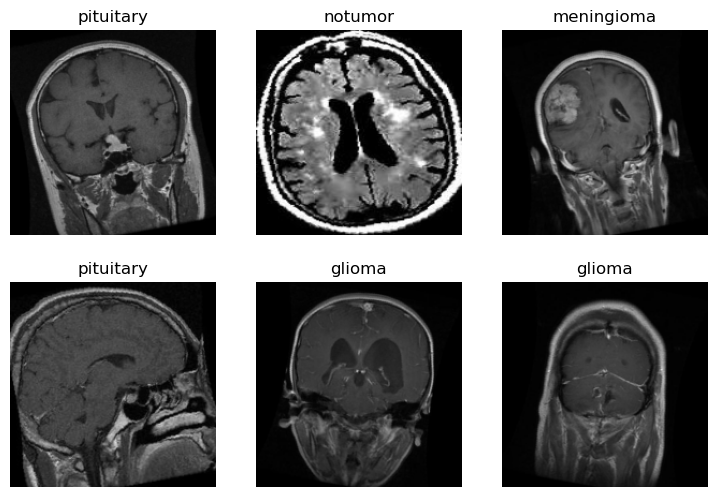

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [108]:
learn = vision_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.555003,0.471872,0.112919,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.321989,0.309889,0.090909,00:59
1,0.117222,0.345543,0.046890,00:59
2,0.038105,0.292582,0.037321,01:00


In [141]:
clas,_,probs = learner.predict(PILImage.create('/kaggle/input/code-to-cure-10/Testing/0017.jpg'))
print(f"This is a: {clas}.")

This is a: meningioma.


In [142]:
# define path to your test set
test_path = '/kaggle/input/code-to-cure-10/Testing'

# create a dataloader for the test set
test_dl = learner.dls.test_dl(get_image_files(test_path))

# get predictions for all images in the test set
preds, _ = learner.get_preds(dl=test_dl)

# get the predicted labels as integers
labels = preds.argmax(dim=1)

In [143]:
labels.shape


torch.Size([480])

In [144]:
df = pd.DataFrame(labels)

In [145]:
df.index.name = 'ID'
df.columns = ['Label'] 

In [62]:
df.to_csv('submission_epcohs_10.csv', index=False)

In [41]:
# filename = os.listdir("/kaggle/input/code-to-cure-10/Testing")

In [44]:
names = []
for x in filename : 
    names.append(x[1:4])

In [146]:
df['ID'] = names

In [147]:
df

,Label,ID
ID,,
0,1,733
1,2,285
2,0,077
3,3,989
4,2,235
...,...,...
475,3,526
476,0,001
477,3,492


In [148]:
df.to_csv('submission_96.csv' , index=False)

In [149]:
df

,Label,ID
ID,,
0,1,733
1,2,285
2,0,077
3,3,989
4,2,235
...,...,...
475,3,526
476,0,001
477,3,492


In [150]:
#################using timm to load more models

In [152]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)


In [161]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [162]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [163]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [166]:
learn_rexnet = timm_learner(dls, 'convnext_large_in22ft1k', metrics=[error_rate, accuracy], cbs=[SaveModelCallback()])


NameError: name 'create_model' is not defined